In [251]:
import numpy as np
from scipy.stats import norm
from scipy.special import erf
import torch
from torch import nn
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt
from tqdm import tqdm
from glob import glob

## FakeData

In [258]:
pattern = "fakedata/Data_*.txt*"

data_files = glob(pattern)

#random.shuffle(data_files)

tot_max = len(data_files)
boot_max = tot_max

Ntotdata = len(np.loadtxt(data_files[0], unpack=True))
# df = pd.read_csv(data_files[0], header=None, names=['Value'])
time_max = 100
num_samples = 10000

input = np.ndarray(shape = (tot_max, time_max))
output = np.ndarray(shape = (tot_max, num_samples))

#for ind,file in enumerate(data_files):
for ind in range(0,tot_max):
    #x_temp = np.loadtxt(file, unpack=True)
    x_temp = np.loadtxt(data_files[ind], unpack=True)
    input[ind] = x_temp[0:time_max]
    output[ind] = x_temp[Ntotdata-num_samples:]

print(len(output[boot_max-1]), boot_max)    
    
num_train = boot_max - 1
num_test = boot_max - 1 # boot_max - 1

input_train = input[0:num_train,:]
input_test = input[num_test,:]


out_train = output[0:num_train,:]
out_test = output[num_test,:]

10000 2842


## Harmonic oscillator

In [259]:
boot, time, corr = np.loadtxt("bootstrap/bootstrap1k_mean_secondofile.dat", unpack=True)

time_max = int(np.max(time) + 1)
boot_max = int(np.max(boot))

#num_train = boot_max - 1
num_test = int(boot_max/2) #boot_max-1 #boot_max - num_train

input = np.ndarray(shape = (boot_max, time_max))
for ind, elem in enumerate(input):
    auxind = ind * time_max
    input[ind] = np.array([corr[ii + auxind] for ii in range(0,time_max)])

num_test = 0
#input_train = input[0:num_train,:]
input_test = input[num_test,:]
print(input_test)
    
num_samples = 10000
x = np.linspace(0, 0.3, num_samples)
etaharm = 0.05
smear_sigma = 0.01

aux_zeta = 0.5 + 0.5 * erf(etaharm/np.sqrt(2)/smear_sigma)

pdf = 1./2.**0.5/aux_zeta*norm.pdf(x, loc = etaharm, scale = smear_sigma)

pdf2 = 1./2.**(3./2.)/aux_zeta*( norm.pdf(x, loc = etaharm, scale = smear_sigma) + 1./9.*norm.pdf(x, loc = 3*etaharm, scale = smear_sigma) )
##plt.plot(x, pdf)
##plt.show()

#out_train = np.ndarray(shape = (num_train, num_samples))
#for ii in range(0, num_train):
#    out_train[ii] = 1./2./np.sqrt(np.pi*smear_sigma)*pdf

[0.49208068 0.46830312 0.44550402 0.42402797 0.40361601 0.38405484
 0.36531163 0.3477342  0.33086276 0.31486014 0.29964113 0.28534082
 0.27157928 0.25831779 0.24576166 0.23380711 0.22251643 0.21160233
 0.20114351 0.19146617 0.18193825 0.17311959 0.16474665 0.15674739
 0.14927064 0.14214841 0.13522236 0.12893383 0.12270467 0.11677858
 0.11121707 0.105946   0.10076213 0.09594689 0.09121749 0.08664718
 0.08238929 0.07835542 0.07465804 0.07097652 0.06745624 0.06405754
 0.06086711 0.05775681 0.05498008 0.05226143 0.04961268 0.04712296
 0.04485045 0.04248805 0.04031925 0.03836886 0.03660317 0.03476519
 0.03324224 0.0317494  0.03027696 0.02889792 0.02753801 0.02624926
 0.02495219 0.02382626 0.02282857 0.02170092 0.02076953 0.01972829
 0.01888831 0.01796245 0.01712499 0.01638248 0.01556521 0.01501843
 0.01423189 0.0136461  0.01297881 0.01241608 0.01198558 0.01147195
 0.01113957 0.01063096 0.00998037 0.00976694 0.00922379 0.00884931
 0.00859391 0.00821588 0.00785453 0.00753091 0.00731882 0.0071

## Neural Network

#### Parameters

In [281]:
hid_size = 128
hid_size2 = 128
learning_rate = 0.005

#### Net

In [286]:
class netNeur(nn.Module):

    def __init__(self):
        super(netNeur, self).__init__()
        self.layer1=nn.Linear(len(input_train[0,:]), hid_size)
        self.activation1=nn.ReLU()
        self.layer2=nn.Linear(hid_size,hid_size2)
        self.activation2=nn.ReLU() #nn.GELU() #nn.ReLU() #nn.Tanh()
        self.layer3=nn.Linear(hid_size2,hid_size2)
        self.layer4=nn.Linear(hid_size2,len(out_train[0,:]))
        #self.activation3=torch.norm()

    def forward(self, x):
        #print(x.dtype)
        #print(self.layer1.weight.dtype)
        x = x.to(self.layer1.weight.dtype)
        x=self.layer1(x)
        x=self.activation1(x)
        x=self.layer2(x)
        x=self.activation2(x)
        x=self.layer3(x)
        x=self.activation2(x)
        x=self.layer4(x)
        #x=self.activation2(x)
        return x

loss_fun=nn.MSELoss()


rete=netNeur()

losses = []
n_discr = int(num_train/1)
dstep = int((num_train-1)/n_discr + 1)

optimizer = torch.optim.Adam(rete.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(rete.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for j in range(4):
    #for i in range(0,n_discr):
    for i in tqdm(range(n_discr), desc="Progress", ncols=100):
        #optimizer = torch.optim.Adam(rete.parameters(), lr=0.01)
        in_train = torch.tensor(input_train[i*dstep:(i+1)*dstep,:])
        in_train = in_train.float()
        #in_train = in_train.squeeze()
        #input_train = input_train.reshape((dstep, len(phi_train[0,:])))
        #print(input_train)
        #p = torch.randn((100,2))*10
        target = torch.tensor(out_train[i*dstep:(i+1)*dstep,:])
        target = target.float()
        #target = target.squeeze()
        #target = target.unsqueeze(1)
        #target = torch.tensor([2.0])
        result=rete.forward(in_train)
        #print(target.dtype)
        #print(result.dtype)
        #print(target, result)
        loss=loss_fun(target, result)
        losses.append(loss.item())
        optimizer.zero_grad()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        #sys.exit()
        #print(loss)
        #for p in rete.parameters():
        #    p.data.sub_(0.001*p.grad)

        #rete.zero_grad()

Progress: 100%|████████████████████████████████████████████████| 2841/2841 [00:20<00:00, 137.05it/s]


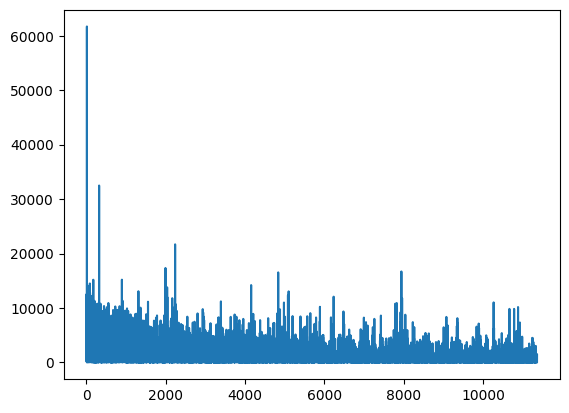

In [287]:
plt.plot(losses)

In [288]:
print(len(input_train[0,:]), len(input_test))

#n_discr = num_test
#dstep = int((num_test-1)/n_discr + 1)
in_test = torch.tensor(input_test)

rete.eval()

with torch.no_grad():
    out_net = rete(in_test)


#out_net = distribNTKgp(input_test, input_train, out_train, eta, n_layer, sigma_w, sigma_b, n0)

100 100


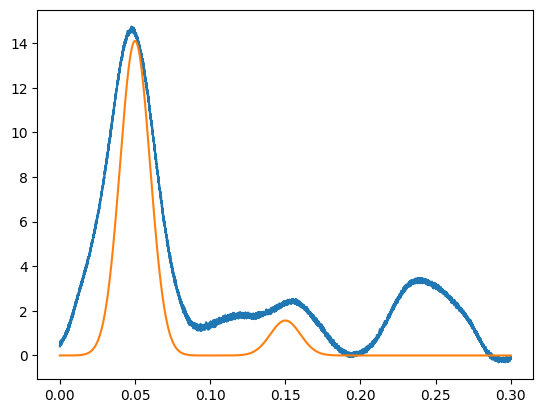

In [289]:
#print(out_net, len(input_test))
plt.plot(x, out_net)
#plt.xlim([0,10])
plt.plot(x, pdf2)#out_test)
plt.show()